### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Polimi/3/Notebooks

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Polimi/3/Notebooks


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 8.2 MB/s 


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Class labels:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

In [ ]:
# Download the data
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.cifar10.load_data()
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

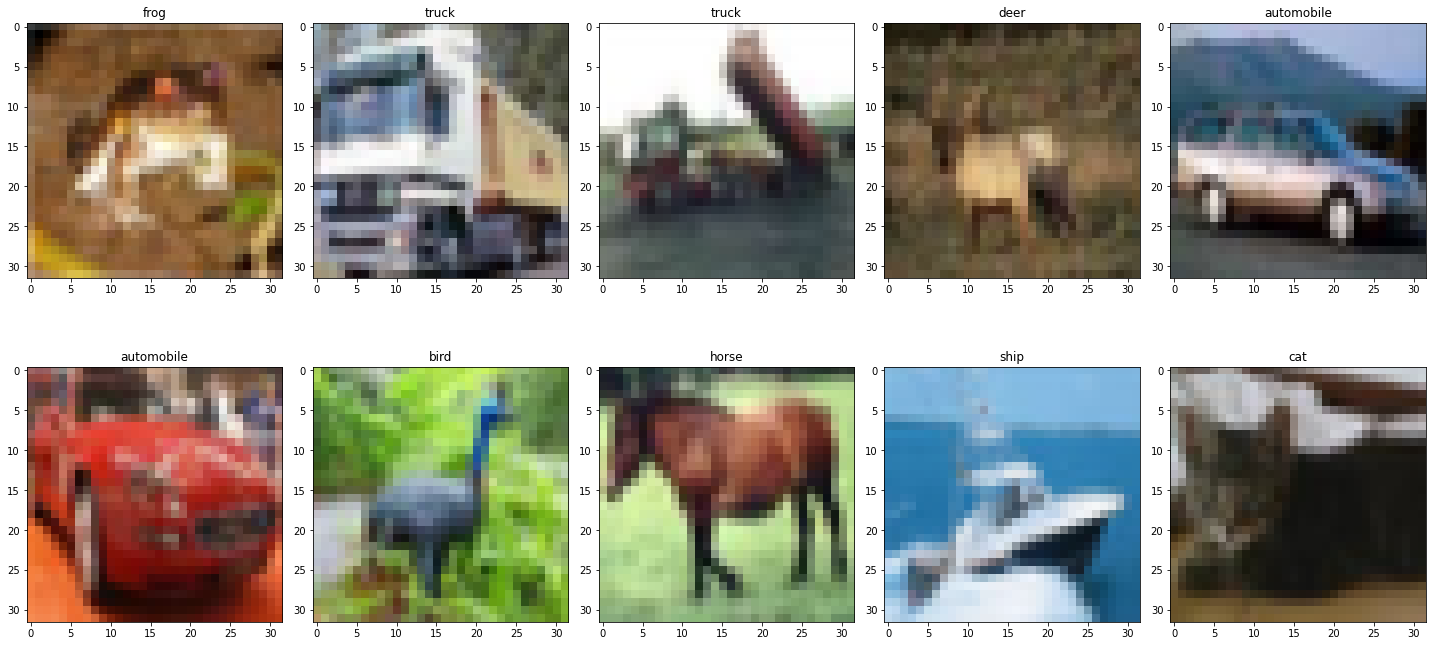

In [ ]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train_val[i])
    ax.set_title('{}'.format(labels[y_train_val[i][0]]))
plt.tight_layout()
plt.show()

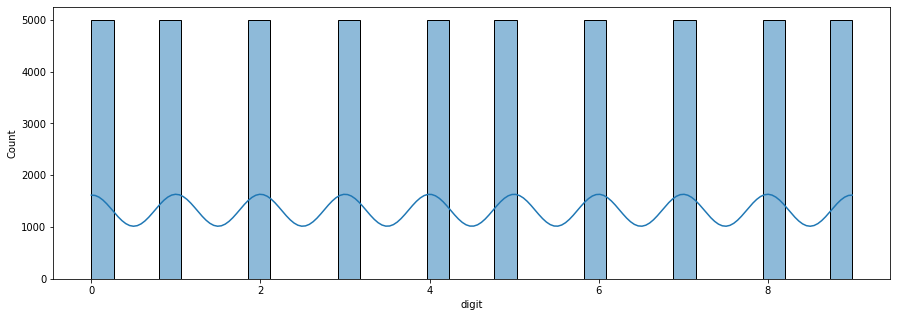

In [ ]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(y_train_val, columns=['digit']), x='digit', kde=True)
plt.show()

### Process data

In [ ]:
# Normalize data
X_train_val = X_train_val/255.
X_test = X_test/255.

# Convert the label to categorical
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Split in train and test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.1, stratify=y_train_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((45000, 32, 32, 3), (45000, 10), (5000, 32, 32, 3), (5000, 10))

In [ ]:
# Compare categorical and "default" labels
print('Categorical label:',y_train[0])
print('"Default" label:',np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 8


### Models metadata

In [ ]:
input_shape = X_train.shape[1:]
batch_size = 128
epochs = 200

### CNN model

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=10, activation='softmax', name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0     

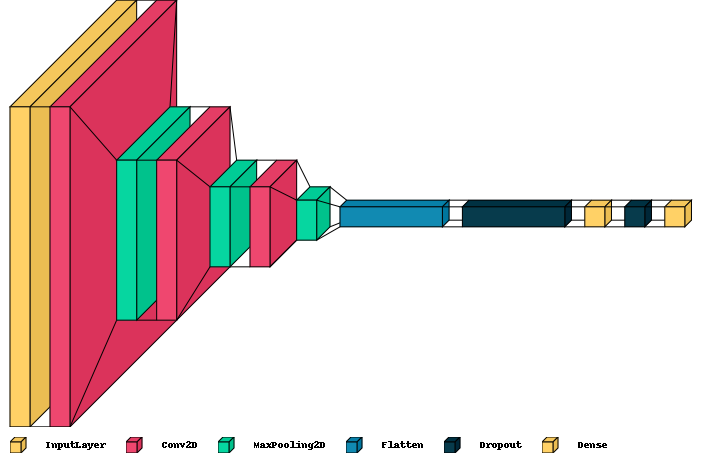

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
352/352 [==============================] - 44s 122ms/step - loss: 1.7424 - accuracy: 0.3603 - val_loss: 1.4407 - val_accuracy: 0.4866
Epoch 2/200
352/352 [==============================] - 43s 122ms/step - loss: 1.3938 - accuracy: 0.4963 - val_loss: 1.2337 - val_accuracy: 0.5682
Epoch 3/200
352/352 [==============================] - 43s 122ms/step - loss: 1.2530 - accuracy: 0.5536 - val_loss: 1.1237 - val_accuracy: 0.6010
Epoch 4/200
352/352 [==============================] - 43s 122ms/step - loss: 1.1587 - accuracy: 0.5911 - val_loss: 1.0289 - val_accuracy: 0.6384
Epoch 5/200
352/352 [==============================] - 43s 122ms/step - loss: 1.0848 - accuracy: 0.6175 - val_loss: 0.9731 - val_accuracy: 0.6622
Epoch 6/200
352/352 [==============================] - 43s 121ms/step - loss: 1.0236 - accuracy: 0.6398 - val_loss: 0.9267 - val_accuracy: 0.6784
Epoch 7/200
352/352 [==============================] - 43s 121ms/step - loss: 0.9817 - accuracy: 0.6540 - val_loss: 0.9243 -

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# model.save('CNN')
model = tfk.models.load_model('CNN')

INFO:tensorflow:Assets written to: CNN/assets


INFO:tensorflow:Assets written to: CNN/assets


In [ ]:
# Predict the test set with the CNN
predictions = model.predict(X_test)
predictions.shape

(10000, 10)

[1.2281247e-07 9.0216986e-07 1.0589722e-03 2.1049928e-02 1.1875618e-02
 9.2314295e-03 9.5673776e-01 3.5576402e-05 7.2292210e-07 8.8222941e-06]


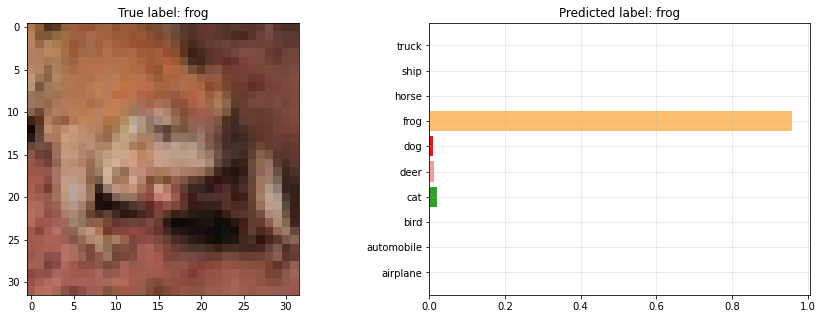

In [ ]:
# Plot the target images and the predictions
prediction_index = 5

print(predictions[prediction_index])

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()

# Classification metrics
## Binary classification

![](https://miro.medium.com/max/1400/1*PPgItHcPSaskyjLMWFC-Kw.png
)

##$Accuracy$ = $\frac{TP+TN}{TP+FP+TN+FN}$

##$Precision$ = $\frac{TP}{TP+FP}$

##$Recall$ = $\frac{TP}{TP+FN}$

##$F1$ = $2\frac{precision \cdot recall}{precision+recall}$

## Categorical classification (Macro averaging)

![](https://www.researchgate.net/profile/Frank-Krueger-2/publication/314116591/figure/fig7/AS:614085901185031@1523420896093/Confusion-matrix-for-multi-class-classification-The-confusion-matrix-of-a_W640.jpg)

##$Accuracy$ = $\frac{diag(CM)}{sum(CM)}$

##$Precision_k$ = $\frac{TP_k}{TP_k+FP_k}$

##$Precision$ = $\frac{\sum_k^n precision_k}{n}$

##$Recall_k$ = $\frac{TP_k}{TP_k+FN_k}$

##$Recall$ = $\frac{\sum_k^n recall_k}{n}$

##$F1$ = $2\frac{precision \cdot recall}{precision+recall}$

Accuracy: 0.7604
Precision: 0.759
Recall: 0.7604
F1: 0.7587


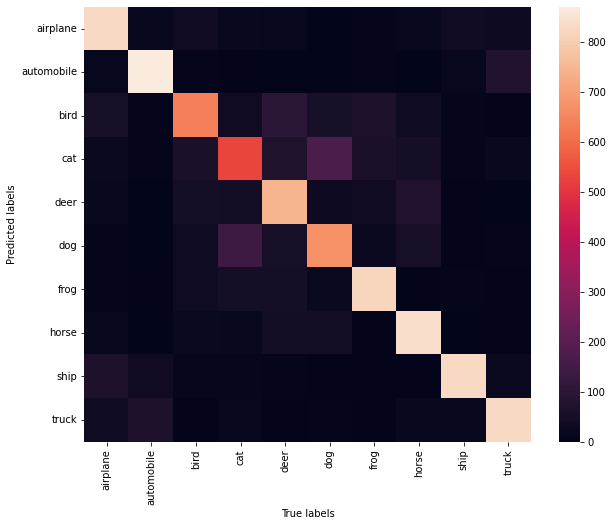

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

What about "deep" learning?

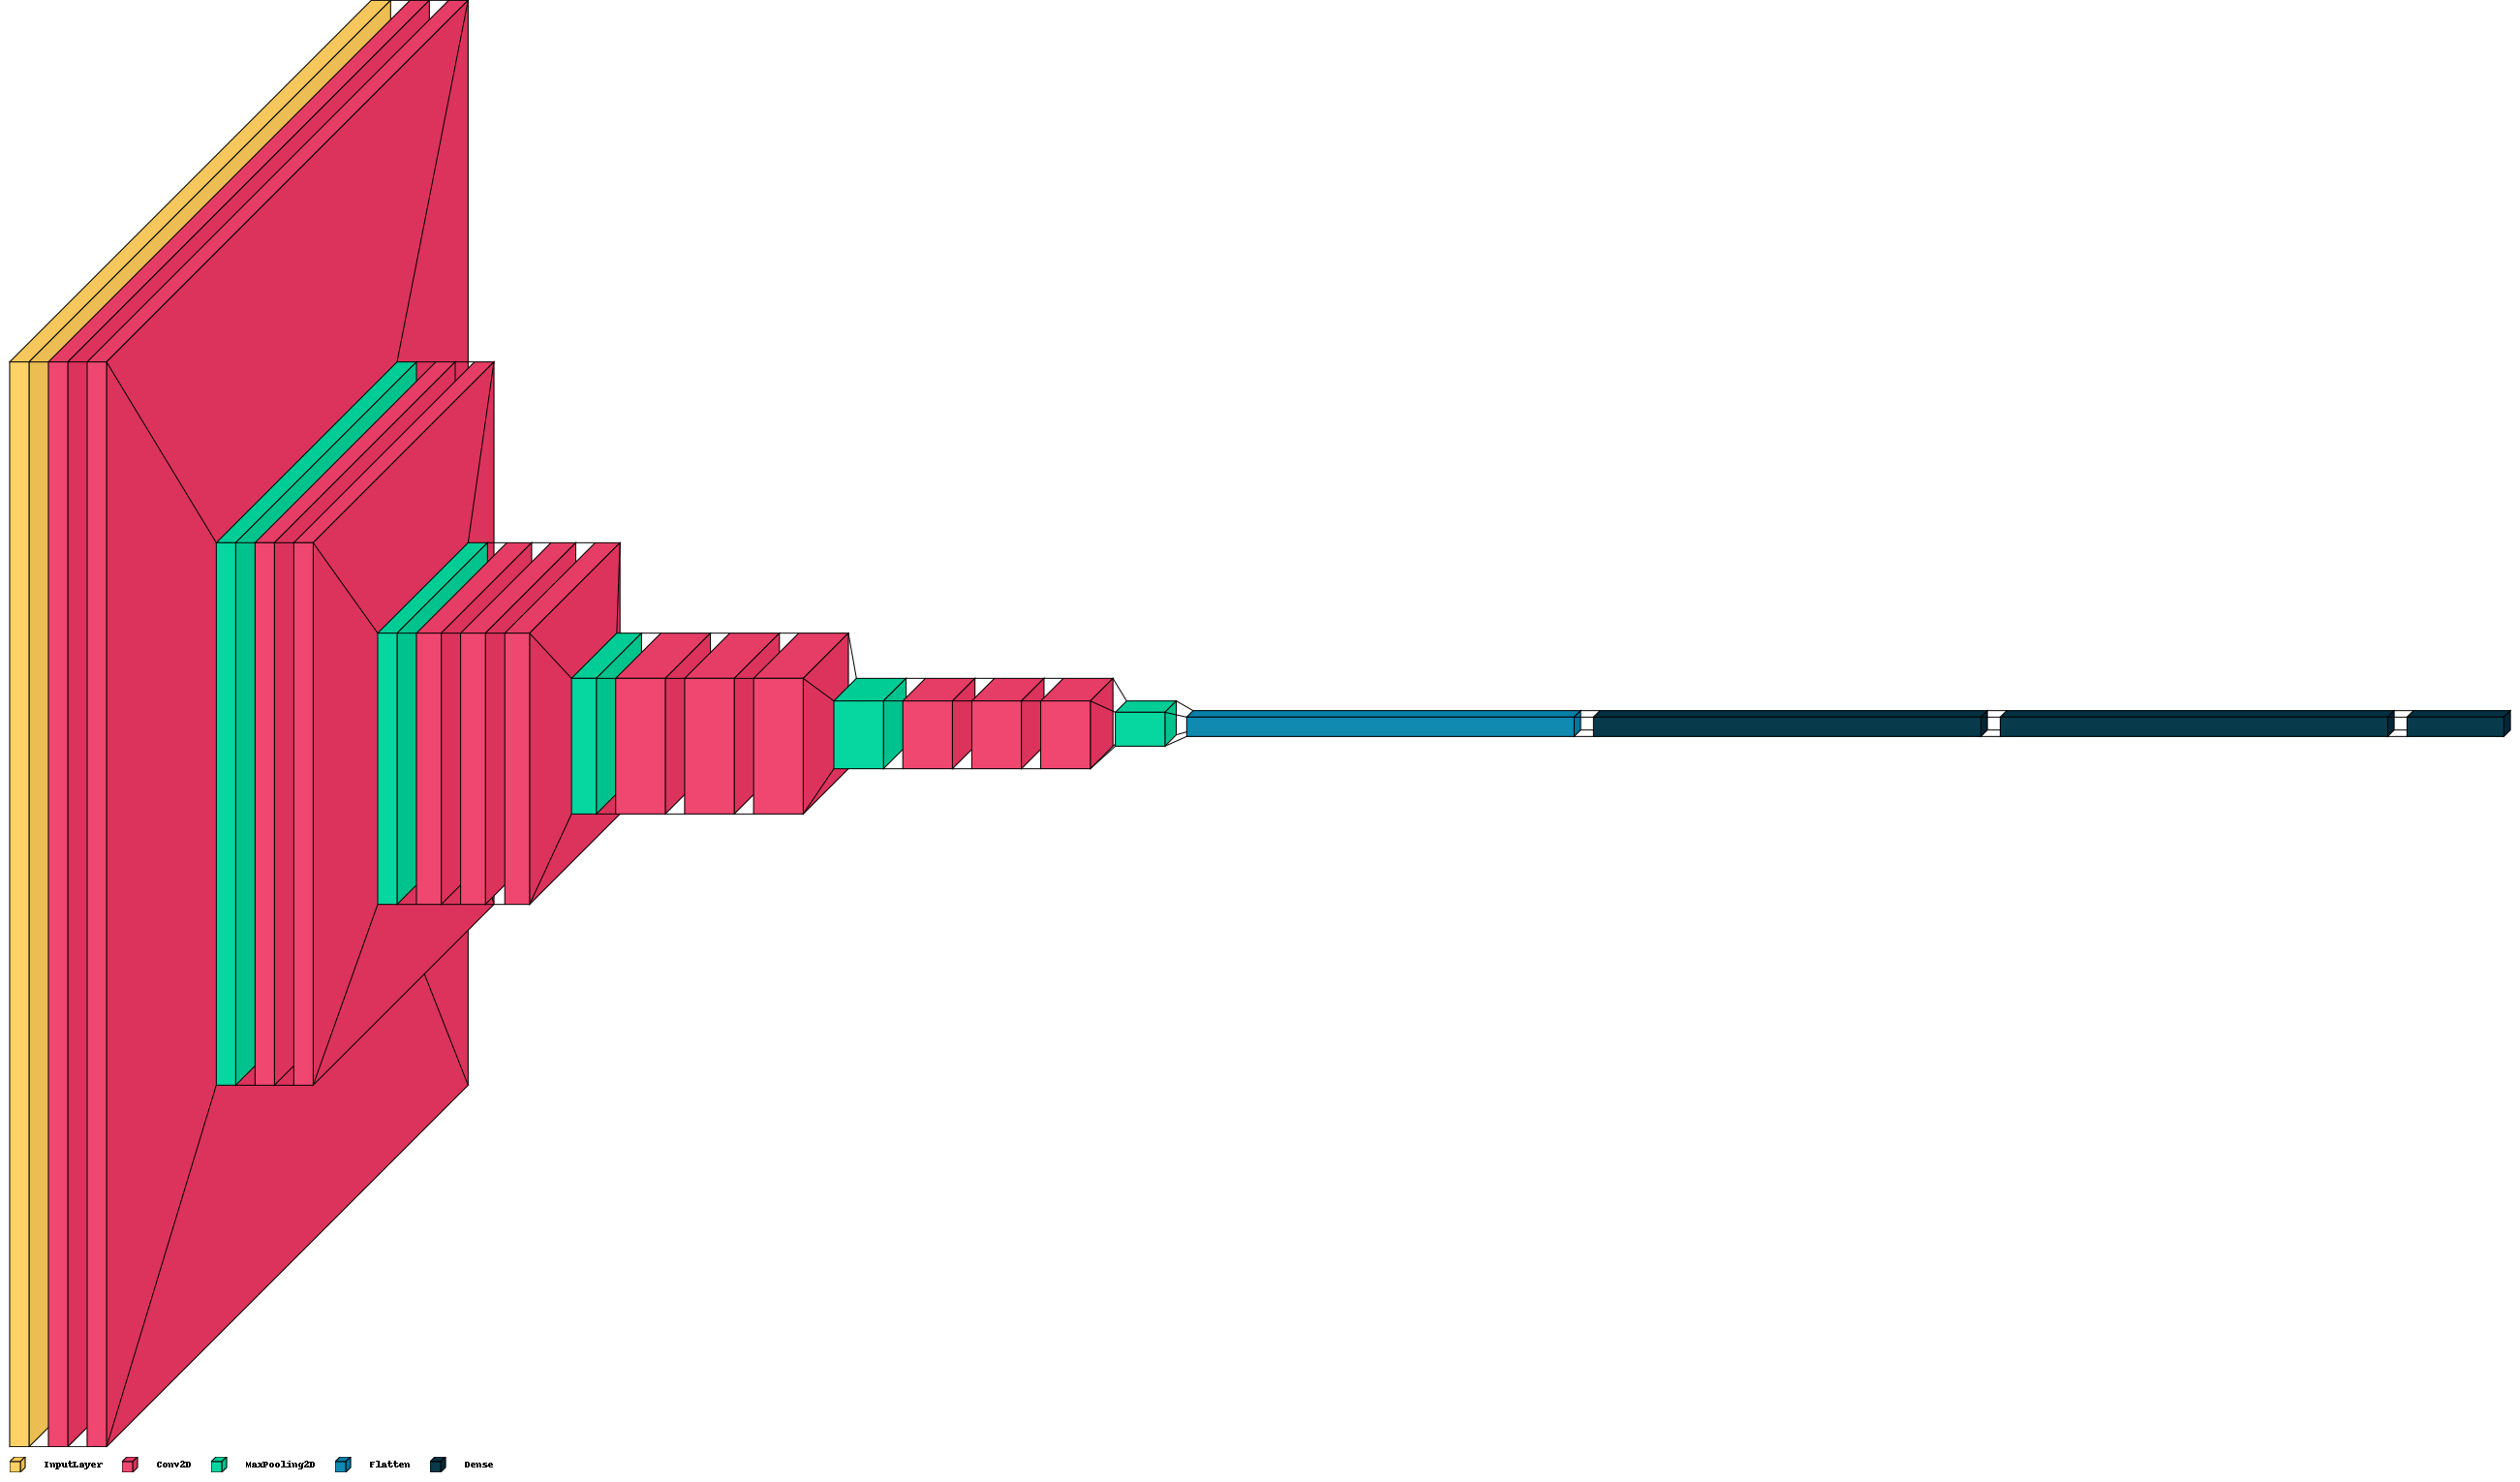

In [ ]:
# Download and plot the VGG16 Net
vgg = tfk.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
visualkeras.layered_view(vgg, legend=True, spacing=20, scale_xy=5)

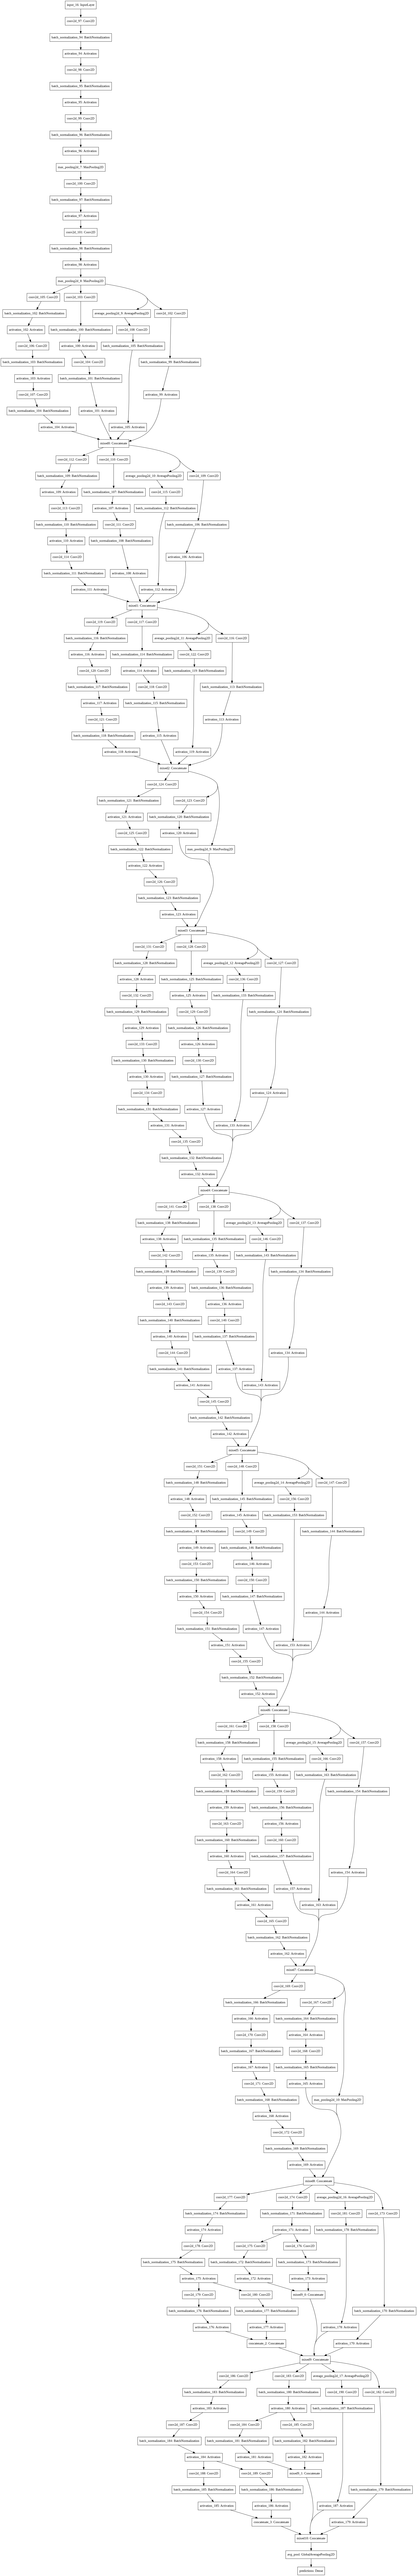

In [ ]:
# Download and plot the InceptionV3 Net
inception = tfk.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
tfk.utils.plot_model(inception)